In [1]:
import heuristic_triangleinequality
import kpp
import numpy as np
import time
import re
import threading
import copy
from matplotlib import pyplot as plt

In [2]:
lock = threading.Lock()
class Server:
    def __init__(self, data=[]):
        self.data = data
    # Return data and new index for incoming request
    def getData(self, currentIndex, batchSize):
        dataLen = len(self.data)
        if currentIndex < dataLen:
            endIndex = currentIndex + batchSize
            endIndex = endIndex if endIndex <= dataLen else dataLen
            return self.data[currentIndex:endIndex], endIndex
        else:
            return [], dataLen

class CurrentData:
    currentData = []
    hasNewData = True
    def __init__(self, currentIndex, batchSize):
        self.currentIndex = currentIndex
        self.trainedIndex = currentIndex
        self.batchSize = batchSize
    def getDataFromServer(self, server):
        with lock:
            print("Get data from server...", end="")
            tempCurrentData, tempCurrentIndex = server.getData(self.currentIndex, self.batchSize)
            if(tempCurrentIndex > self.currentIndex):
                self.hasNewData = True
                self.currentData += tempCurrentData
                self.currentIndex = tempCurrentIndex
            else:
                self.hasNewData = False
            print("Done")
    def getDataLen(self):
        with lock:
            return len(self.currentData)
    def getData(self):
        with lock:
            return self.currentData
    def clearCurrentData(self):
        with lock:
            self.currentData = []
    def updateTrainedIndex(self, newIndex):
        with lock:
            self.trainedIndex = newIndex
class Model:
    clusters = []
    currentIndex = 0
    def __init__(self, currentData, numClusters, rememberClusters):
        self.currentData = currentData
        self.dim = len(self.currentData.currentData[0])
        self.numClusters = numClusters
        self.rememberClusters = rememberClusters
        self.createClusterCentroids()
    def createClusterCentroids(self):
        firstData = np.array(self.currentData.currentData)
        firstDataLen = len(self.currentData.currentData)
        kplus = kpp.KPP(K=self.numClusters, X=firstData, N=firstDataLen)
        kplus.init_centers()
        self.clusters = [kpp.Point(x,len(x)) for x in kplus.mu]
    def startTraining(self):
        start = time.time()

        # Get current data and index
        with lock:
            tempData = copy.deepcopy(self.currentData.currentData)
            tempIndex = self.currentData.currentIndex
        config1 = heuristic_triangleinequality.Kmeans(self.numClusters, tempData, 1, 40, self.clusters)
        self.clusters = [saveCluster(x) for x in config1.centroidList]
        self.currentData.updateTrainedIndex(tempIndex) # Update trained index to data storage
        print ("Time taken:", time.time() - start, end="\n\n")

# Utils
def saveCluster(x):
    x.point.pointList = x.pointList
    return x.point
def getFileData(path):
    data = []
    with open(path, "r") as f:
        for _, l in enumerate(f):
            data += [[float(x) for x in re.compile("[0-9]+").findall(l)]]
            pass
    return data
def makeRandomPoint(n, lower, upper):
    return np.random.normal(loc=upper, size=[lower, n])
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# Threads
def getDataFromServer(server, currentData):
    while 1:
        # Always check for new data
        currentData.getDataFromServer(server)
        # Turn off thread if no new data is coming
        if not currentData.hasNewData:
            break
def training(model, currentData):
    while 1:
        # Always check for new data, only training if new data has goten
        if currentData.trainedIndex < currentData.currentIndex:
            model.startTraining()
        # Turn off thread if no new data is coming
        if currentData.trainedIndex == currentData.currentIndex:
            break

Create server...Done
Create temporary data...Done
Get data from server...Done
Create model...Done

Get data from server...Done
Centroids to Remember: 2
Iteration: 1 Error: 2323697689945870.5
Iteration: 2 Error: 1860770654033683.0
Iteration: 3 Error: 1826663992458677.0
Extra Iteration Error: 1788308560724285.5
Time taken: 11.437160968780518



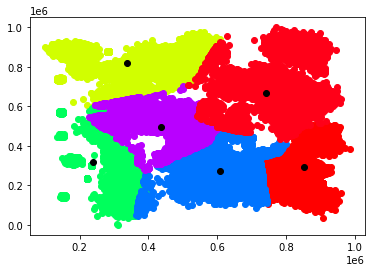

In [4]:
print("Create server...", end="")
server = Server(getFileData("./../data/birch.txt"))
print("Done")

print("Create temporary data...", end="")
currentData = CurrentData(currentIndex=0, batchSize=100000)
print("Done")
currentData.getDataFromServer(server)

print("Create model...", end="")
model = Model(currentData, numClusters=6, rememberClusters=6)
print("Done\n")

# Start threads
d = threading.Thread(name='Get data thread', target=getDataFromServer, args=[server, currentData])
t = threading.Thread(name='Training thread', target=training, args=[model, currentData])
# t.setDaemon(True) # If d thread off t thread will off automatically

d.start()
t.start()

d.join()
t.join()

# Visualize
cmap = get_cmap(len(model.clusters))
for index, cluster in enumerate(model.clusters):
    x, y = np.array([cluster.coordinates]).T
    plt.scatter(x, y, c="black", zorder=2)
    arr = []
    arr += [x.coordinates for x in cluster.pointList]
    x, y = np.array(arr).T
    plt.scatter(x, y, color=cmap(index))
plt.show()